# Imports and setup

In [1]:
# We can now load the dependencies
from IPython.display import clear_output
%matplotlib inline 
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt 
import torchvision
from tqdm import tqdm
import torch.optim as optim
import torchmetrics
import pandas as pd
import json

# If VSCode doesn't pick up this import, see answer here: 
# https://stackoverflow.com/questions/65252074/import-path-to-own-script-could-not-be-resolved-pylance-reportmissingimports
import sys
sys.path.append("../../Datasets/")
from Custom_Dataset import * 

We can start by setting a seed for reproducibility

In [2]:
torch.manual_seed(0)

# Pre-processing

We start by defining a custom dataset which loads the data from disk lazily. This is because we have too many training examples to keep all of them in memory at once. The CustomDataset class is defined in Datasets/Cutsom_Dataset.py

In [3]:
# Extract the generated data
train_gen_dataset = CustomDataset("Generated", "train", balance = True)
val_gen_dataset = CustomDataset("Generated", "validation", balance=True)
test_gen_dataset = CustomDataset("Generated", "test", balance=True)

# Extract the real data in full
train_real_dataset = CustomDataset("Real Life", "train", balance=True)
val_real_dataset = CustomDataset("Real Life", "validation", balance=True)
test_real_dataset = CustomDataset("Real Life", "test", balance=True)

# Extract a version of the real data where the training set is just 80% of the full validation set
# The validation set becomes 20% of the initial validation set
train_real_dataset_full_val_subset= CustomDataset("Real Life", "validation", balance=True, filter_array = np.arange(0, int(0.8*len(val_real_dataset))))
val_real_dataset_full_val_subset = CustomDataset("Real Life", "validation", balance=True, filter_array = np.arange(int(0.8*len(val_real_dataset)), len(val_real_dataset)))


# Hyperparameter choices

We create a cell to hold the hyperparameters of the model to tune.

In [4]:
batch_size = 100 # Each the real and generated data will be split into batches of this size (Since we only train on generated here)
dropout_rate_choices = {0, 0.2, 0.5}
gamma_focal_loss_choices = {0, 2, 5} # Choices for the gamma parameter in the focal loss
learning_rate = 0.001
n_validation = 30 # Number of iterations between each validation run
n_validation_minibatches = 5 # Number of minibatches to use for validation every n_validation iterations
num_epochs = 5

# Model implementation

We can start by loading a pre-trained VGG16 model without the classification layers towards the end (Only the feature extractor).

In [5]:
vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1')

We can now visualize its layers:

In [6]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Because we are looking for a pre-trained feature extractor here, we decide to only use the features part and freeze its weights. We can then add a few subsequent layers to fine tune predictions. We can thus define the following model:

In [7]:
class BaseModel(nn.Module):

    def __init__(self, num_classes=13, dropout_rate=0.5):
        
        super(BaseModel, self).__init__()
        
        # Define the layers of the model
        self.features = torchvision.models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features
        self.classifier = nn.Sequential(
            nn.Linear(4608, 1024),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

        # Set the features to not require gradients
        for param in self.features.parameters():
            param.requires_grad = False


    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Training

We can start by finding the device to use for training:

In [8]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.has_mps:
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

if DEVICE == "cuda":
    torch.cuda.empty_cache()

print("Device:", DEVICE)

Device: cuda


We can then go ahead and define the loss function we will be using. Because we will opt for a balanced focal loss instead of a regular cross entropy loss which gives more importance to the classes that are harder to classify. We thus implement the focal loss defined by the following formula:
$$
FL(p_t) = -(1-p_t^{\gamma})log(p_t)
$$

where gamma $\gamma$ is a tunable hyperparameter. We can also further add an alpha term to handle class imbalance, making our loss function a class-balanced focal loss, as shown in https://github.com/AdeelH/pytorch-multi-class-focal-loss. 
Note: Since we have balanced classes thanks to oversmapling, we will not use the alpha parameter.



Finally, we need an accuracy metric to tune the hyperparameters of the model. We will opt for a balanced accuracy score, which is just regular classification accuracy but adapted to weigh each class by its frequency:

In [9]:
# Define the accuracy metrics
f1_score = torchmetrics.F1Score(task="multiclass", num_classes=13, average="weighted").to(DEVICE)
accuracy = torchmetrics.Accuracy(task="multiclass", num_classes=13, average="weighted").to(DEVICE)

We can now load a single example from the loader and display its label as well as its class proportion, which should be around 1/13 which is +- 8%.

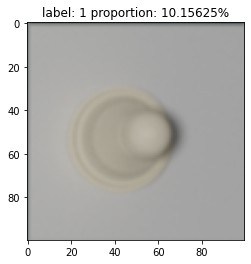

In [10]:
gen_train_loader = get_loader(train_gen_dataset, batch_size=128)

for i, (images, labels) in enumerate(gen_train_loader):
    class_proportions = [(labels == i).sum() / len(labels) for i in range(13)]
    plt.title("label: " + str(labels[0].item()) + " proportion: " + str(class_proportions[labels[0].item()].item() * 100) + "%")
    plt.imshow(images[0].permute(1, 2, 0))
    break

We can also define the following functions for saving the metrics collected during training (Depeding of which training strategy is being used: Training on generated data or on the real life data). We will plot these metrics later in the Results.ipynb file.

In [11]:
def save_metrics_to_json_train_gen(gen_training_losses, gen_training_accs, gen_training_f1s, \
                         gen_validation_losses, gen_validation_accs, gen_validation_f1s, \
                            real_validation_losses, real_validation_accs, real_validation_f1s, \
                                real_validation_accs_full, gamma, batch_size, dropout_rate, learning_rate, \
                                    n_validation, n_validation_minibatches, num_epochs, best_real_acc, best_epoch):
        
    json_data = {
        "metrics": {
            "gen_training_losses/iteration": gen_training_losses,
            "gen_training_accs/iteration": gen_training_accs,
            "gen_training_f1s/iteration": gen_training_f1s,
            "gen_validation_losses/n_validation": gen_validation_losses,
            "gen_validation_accs/n_validation": gen_validation_accs,
            "gen_validation_f1s/n_validation": gen_validation_f1s,
            "real_validation_losses/n_validation": real_validation_losses,
            "real_validation_accs/n_validation": real_validation_accs,
            "real_validation_f1s/n_validation": real_validation_f1s,
            "real_validation_accs_full/epoch": real_validation_accs_full
        },
        "hyperparameters": {
            "gamma": gamma,
            "batch_size": batch_size,
            "dropout_rate": dropout_rate,
            "learning_rate": learning_rate,
            "n_validation": n_validation,
            "n_validation_minibatches": n_validation_minibatches,
            "num_epochs": num_epochs
        },
        "peak_performance": {
            "best_real_acc": best_real_acc,
            "best_epoch": best_epoch
        }
    }

    with open(f"TRAIN_GEN/HP tuning results/gamma_{str(gamma)}_batch_{str(batch_size)}_dropout_{str(dropout_rate)}.json", "w") as json_file:
        json.dump(json_data, json_file)


def save_metrics_to_json_train_real(real_training_losses, real_training_accs, real_training_f1s, \
                                   real_validation_losses, real_validation_accs, real_validation_f1s, \
                                   real_validation_accs_full, gamma, batch_size, dropout_rate, learning_rate, \
                                   n_validation, n_validation_minibatches, num_epochs, best_real_acc, best_epoch, \
                                   full_dataset_used):

    json_data = {
        "metrics": {
            "real_training_losses/iteration": real_training_losses,
            "real_training_accs/iteration": real_training_accs,
            "real_training_f1s/iteration": real_training_f1s,
            "real_validation_losses/n_validation": real_validation_losses,
            "real_validation_accs/n_validation": real_validation_accs,
            "real_validation_f1s/n_validation": real_validation_f1s,
            "real_validation_accs_full/epoch": real_validation_accs_full
        },
        "hyperparameters": {
            "gamma": gamma,
            "batch_size": batch_size,
            "dropout_rate": dropout_rate,
            "learning_rate": learning_rate,
            "n_validation": n_validation,
            "n_validation_minibatches": n_validation_minibatches,
            "num_epochs": num_epochs
        },
        "peak_performance": {
            "best_real_acc": best_real_acc,
            "best_epoch": best_epoch
        }
    }

    folder = "TRAIN_FULL_REAL" if full_dataset_used else "TRAIN_VAL_REAL"
    with open(f"{folder}/HP tuning results/gamma_{str(gamma)}_batch_{str(batch_size)}_dropout_{str(dropout_rate)}.json", "w") as json_file:
        json.dump(json_data, json_file)


We can now define an evaluate function that computes the average accuracy on the full real life validation set.

In [ ]:
def evaluate_epoch(basemodel, real_val_loader):

    # Set the model to eval mode
    basemodel.eval()

    # To compute the average validation accuracy
    acc_val_sum = 0

    # Disable gradient calculation
    with torch.no_grad():

        # Iterate through the full validation set
        for X_val_real, y_val_real in real_val_loader:

            # Move the data to the device
            X_val_real = X_val_real.to(DEVICE)
            y_val_real = y_val_real.to(DEVICE)

            # Forward pass
            y_val_pred_prob_real = basemodel(X_val_real)
            y_val_pred_real = torch.argmax(y_val_pred_prob_real, dim=1)

            # Compute the metrics
            acc_val_sum += accuracy(y_val_pred_real, y_val_real)

    # Compute the average accuracy
    average_real_acc = acc_val_sum / len(real_val_loader)

    return average_real_acc


We can now define a training function we will call for each hyperparameter combination. We again need one training function to train on the real life data and an equivalent to train on the generated data. To differentiate between training on the full and on a subset of the validation portion of the real life data in the real life training function, we will add a parameter called `full_dataset_used` to the latter.

In [12]:
def train_gen(gamma, dropout_rate, batch_size, hyperparameter_combination_number, 
                        learning_rate=learning_rate, n_validation=n_validation, \
                        n_validation_minibatches=n_validation_minibatches, num_epochs=num_epochs):
    
    # Define the data loaders accounting for the batch size
    train_loader = get_loader(train_gen_dataset, batch_size=batch_size)
    gen_val_loader = get_loader(val_gen_dataset, batch_size=batch_size)
    real_val_loader = get_loader(val_real_dataset, batch_size=batch_size)  

    # Define the new loss function (Taking into account gamma)
    focal_loss = torch.hub.load(
        'adeelh/pytorch-multi-class-focal-loss',
        model='FocalLoss',
        gamma=gamma, # No use of alpha since we have balanced classes now with the oversampling
        reduction='mean',
        force_reload=False,
        verbose = False
    ).to(DEVICE)

    basemodel = BaseModel(dropout_rate=dropout_rate).to(DEVICE)      
    opt = optim.Adam(basemodel.parameters(), lr=learning_rate)

    # To store the metrics every iteration on 1 minibatch
    gen_training_losses = []
    gen_training_accs = []
    gen_training_f1s = []

    # To store the metrics every n_validation iterations on n_validation_minibatches
    gen_validation_losses = []
    gen_validation_accs = []
    gen_validation_f1s = []
    real_validation_losses = []
    real_validation_accs = []
    real_validation_f1s = []

    # To store the accuracy of the epoch on the full real validation set
    real_validation_accs_full = []

    # To keep track of the best model (Best epoch)
    best_real_acc = -1
    best_model_state_dict = None
    best_epoch = -1

    # Compute the average accuracy on the validation set at epoch 0
    average_acc = evaluate_epoch(basemodel, real_val_loader)
    real_validation_accs_full.append(average_acc)

    for epoch in range(num_epochs):
        
        # Train the model
        for iteration, (X_train_gen, y_train_gen) in tqdm(enumerate(train_loader)):
            
            # Set the model to training mode
            basemodel.train()

            # Move the data to the device
            X_train_gen = X_train_gen.to(DEVICE)
            y_train_gen = y_train_gen.to(DEVICE)

            # Forward pass
            y_train_pred_raw_gen = basemodel(X_train_gen)
            y_train_pred_gen = torch.argmax(y_train_pred_raw_gen, dim=1)

            # Compute the loss
            loss_train = focal_loss(y_train_pred_raw_gen, y_train_gen.long())

            # Compute the accuracy
            acc_train = accuracy(y_train_pred_gen, y_train_gen)
            f1_train = f1_score(y_train_pred_gen, y_train_gen)

            # Backward pass
            opt.zero_grad()
            loss_train.backward()
            opt.step()

            # Store the loss & accuracy
            gen_training_losses.append(loss_train.item())
            gen_training_accs.append(acc_train.item())
            gen_training_f1s.append(f1_train.item())
            
            # Check if the model should be validated
            if iteration == 0 or (iteration + 1) % n_validation == 0:
                
                # Set the model to evaluation mode
                basemodel.eval()
                
                # Disable gradient calculation
                with torch.no_grad():
                    
                    # 1) Evaluate on the generated validation set
                    acc_val_sum = 0
                    weighted_f1_val_sum = 0
                    loss_val_sum = 0

                    # Extract an iterator from the generated data loader
                    gen_val_iter = iter(gen_val_loader)

                    # Iterate for n_validation_minibatches
                    for _ in range(n_validation_minibatches):

                        # Get the next minibatch
                        minibatch = next(gen_val_iter, None)
                        if minibatch is None:
                            gen_val_iter = iter(gen_val_loader)
                            minibatch = next(gen_val_iter)
                            
                        # Extract the data
                        X_val_gen, y_val_gen = minibatch

                        # Move the data to the device
                        X_val_gen = X_val_gen.to(DEVICE)
                        y_val_gen = y_val_gen.to(DEVICE)

                        # Forward pass
                        y_val_pred_raw_gen = basemodel(X_val_gen)
                        y_val_pred_gen = torch.argmax(y_val_pred_raw_gen, dim=1)

                        # Compute the metrics
                        acc_val_sum += accuracy(y_val_pred_gen, y_val_gen)
                        weighted_f1_val_sum += f1_score(y_val_pred_gen, y_val_gen)
                        loss_val_sum += focal_loss(y_val_pred_raw_gen, y_val_gen)

                    # Compute the average metrics
                    acc_val_gen = acc_val_sum / n_validation_minibatches
                    loss_val_gen = loss_val_sum / n_validation_minibatches
                    weighted_f1_val_gen = weighted_f1_val_sum / n_validation_minibatches


                    # 2) Repeat on the real validation set

                    acc_val_sum = 0
                    weighted_f1_val_sum = 0
                    loss_val_sum = 0

                    # Extract an iterator from the generated data loader
                    real_val_iter = iter(real_val_loader)

                    # Iterate for n_validation_minibatches
                    for _ in range(n_validation_minibatches):

                        # Get the next minibatch
                        minibatch = next(real_val_iter, None)
                        if minibatch is None:
                            real_val_iter = iter(real_val_loader)
                            minibatch = next(real_val_iter)

                        # Extract the data
                        X_val_real, y_val_real = minibatch
                            
                        # Move the data to the device
                        X_val_real = X_val_real.to(DEVICE)
                        y_val_real = y_val_real.to(DEVICE)

                        # Forward pass
                        y_val_pred_raw_real = basemodel(X_val_real)
                        y_val_pred_real = torch.argmax(y_val_pred_raw_real, dim=1)

                        # Compute the metrics
                        acc_val_sum += accuracy(y_val_pred_real, y_val_real)
                        weighted_f1_val_sum += f1_score(y_val_pred_real, y_val_real)
                        loss_val_sum += focal_loss(y_val_pred_raw_real, y_val_real)

                    # Compute the average metrics
                    acc_val_real = acc_val_sum / n_validation_minibatches
                    loss_val_real = loss_val_sum / n_validation_minibatches
                    weighted_f1_val_real = weighted_f1_val_sum / n_validation_minibatches

                    # Store all 6 metrics
                    gen_validation_losses.append(loss_val_gen.item())
                    gen_validation_accs.append(acc_val_gen.item())
                    gen_validation_f1s.append(weighted_f1_val_gen.item())
                    real_validation_losses.append(loss_val_real.item())
                    real_validation_accs.append(acc_val_real.item())
                    real_validation_f1s.append(weighted_f1_val_real.item())

                    # Print an update -- Only show the last print statement
                    clear_output(wait=True)
                    print('----------------------------------------------------------------')
                    print(f'TRAINING HP COMBINATION  [#{hyperparameter_combination_number}] -- EPOCH [{epoch+1}] --  ITERATION [{iteration+1}]')
                    print(f'CURRENT BEST EPOCH: {best_epoch} -- CURRENT BEST FULL VALIDATION SET ACCURACY: {best_real_acc}')
                    print('----------------------------------------------------------------')
                    print(f'TRAINING => Loss: {loss_train} -- Acc: {acc_train} -- F1: {f1_train}')
                    print(f'GENERATED VALIDATION => Loss: {loss_val_gen} -- Acc: {acc_val_gen} -- F1: {weighted_f1_val_gen}')
                    print(f'REAL VALIDATION => Loss: {loss_val_real} -- Acc: {acc_val_real} -- F1: {weighted_f1_val_real}')
                    print('----------------------------------------------------------------')
                    
        # Save the model every epoch as a checkpoint 
        torch.save(basemodel.state_dict(), f'./TRAIN_GEN/checkpoints/basemodel_gamma_{gamma}_dropout_{dropout_rate}_batch_{batch_size}_epoch_{epoch+1}.ckpt')

        # Check whether to overwrite the best model by computing the validation accuracy on the full real life validation set
        average_real_acc = evaluate_epoch(basemodel, real_val_loader)

        # Append the average real validation accuracy of the epoch to the corresponding array
        real_validation_accs_full.append(average_real_acc.item())

        # Check whether the current version of the model is the best one
        if best_model_state_dict is None or average_real_acc > best_real_acc:
            best_real_acc = average_real_acc.item()
            best_model_state_dict = basemodel.state_dict()
            best_epoch = epoch + 1
        
    # Plot and save the metrics
    save_metrics_to_json_train_gen(gen_training_losses, gen_training_accs, gen_training_f1s, gen_validation_losses, \
                                gen_validation_accs, gen_validation_f1s, real_validation_losses, real_validation_accs, \
                                real_validation_f1s, real_validation_accs_full, gamma, batch_size, dropout_rate, learning_rate, \
                                n_validation, n_validation_minibatches, num_epochs, best_real_acc, best_epoch)
    
    return best_model_state_dict, best_real_acc

In [13]:
def train_real(full_dataset_used, gamma, dropout_rate, batch_size, hyperparameter_combination_number,
              learning_rate=learning_rate, n_validation=n_validation,
              n_validation_minibatches=n_validation_minibatches, num_epochs=num_epochs):

    # Define the data loaders accounting for the batch size
    if full_dataset_used:
        train_loader = get_loader(train_real_dataset, batch_size=batch_size)
        val_loader = get_loader(val_real_dataset, batch_size=batch_size)
    else:
        train_loader = get_loader(train_real_dataset_full_val_subset, batch_size=batch_size)
        val_loader = get_loader(val_real_dataset_full_val_subset, batch_size=batch_size)


    # Define the new loss function (Taking into account gamma)
    focal_loss = torch.hub.load(
        'adeelh/pytorch-multi-class-focal-loss',
        model='FocalLoss',
        gamma=gamma,  # No use of alpha since we have balanced classes now with the oversampling
        reduction='mean',
        force_reload=False,
        verbose=False
    ).to(DEVICE)

    basemodel = BaseModel(dropout_rate=dropout_rate).to(DEVICE)
    opt = optim.Adam(basemodel.parameters(), lr=learning_rate)

    # To store the metrics every iteration on 1 minibatch
    training_losses = []
    training_accs = []
    training_f1s = []

    # To store the metrics every n_validation iterations on n_validation_minibatches
    validation_losses = []
    validation_accs = []
    validation_f1s = []

    # To store the accuracy of the epoch on the full real validation set
    validation_accs_full = []

    # Folder to save metrics to
    folder = "TRAIN_FULL_REAL" if full_dataset_used else "TRAIN_VAL_REAL"

    # To keep track of the best model (Best epoch)
    best_acc = -1
    best_model_state_dict = None
    best_epoch = -1

    # Compute the average accuracy on the validation set at epoch 0
    average_acc = evaluate_epoch(basemodel, val_loader)
    validation_accs_full.append(average_acc)

    for epoch in range(num_epochs):

        # Train the model
        for iteration, (X_train, y_train) in tqdm(enumerate(train_loader)):

            # Set the model to training mode
            basemodel.train()

            # Move the data to the device
            X_train = X_train.to(DEVICE)
            y_train = y_train.to(DEVICE)

            # Forward pass
            y_train_pred_raw = basemodel(X_train)
            y_train_pred = torch.argmax(y_train_pred_raw, dim=1)

            # Compute the loss
            loss_train = focal_loss(y_train_pred_raw, y_train.long())

            # Compute the accuracy
            acc_train = accuracy(y_train_pred, y_train)
            f1_train = f1_score(y_train_pred, y_train)

            # Backward pass
            opt.zero_grad()
            loss_train.backward()
            opt.step()

            # Store the loss & accuracy
            training_losses.append(loss_train.item())
            training_accs.append(acc_train.item())
            training_f1s.append(f1_train.item())

            # Check if the model should be validated
            if iteration == 0 or (iteration + 1) % n_validation == 0:

                # Set the model to evaluation mode
                basemodel.eval()

                # Disable gradient calculation
                with torch.no_grad():
                    
                    # Compute all metrics on the real life validation dataset
                    acc_val_sum = 0
                    weighted_f1_val_sum = 0
                    loss_val_sum = 0

                    # Extract an iterator from the generated data loader
                    val_iter = iter(val_loader)

                    # Iterate for n_validation_minibatches
                    for _ in range(n_validation_minibatches):

                        # Get the next minibatch
                        minibatch = next(val_iter, None)
                        if minibatch is None:
                            val_iter = iter(val_loader)
                            minibatch = next(val_iter)

                        # Extract the data
                        X_val, y_val = minibatch

                        # Move the data to the device
                        X_val = X_val.to(DEVICE)
                        y_val = y_val.to(DEVICE)

                        # Forward pass
                        y_val_pred_raw = basemodel(X_val)
                        y_val_pred = torch.argmax(
                            y_val_pred_raw, dim=1)

                        # Compute the metrics
                        acc_val_sum += accuracy(y_val_pred, y_val)
                        weighted_f1_val_sum += f1_score(y_val_pred, y_val)
                        loss_val_sum += focal_loss(y_val_pred_raw, y_val)

                    # Compute the average metrics
                    acc_val = acc_val_sum / n_validation_minibatches
                    loss_val = loss_val_sum / n_validation_minibatches
                    weighted_f1_val = weighted_f1_val_sum / n_validation_minibatches

                    # Store all 6 metrics
                    validation_losses.append(loss_val.item())
                    validation_accs.append(acc_val.item())
                    validation_f1s.append(weighted_f1_val.item())

                    # Print an update -- Only show the last print statement
                    clear_output(wait=True)
                    print('----------------------------------------------------------------')
                    print(f'TRAINING HP COMBINATION  [#{hyperparameter_combination_number}] -- EPOCH [{epoch+1}] --  ITERATION [{iteration+1}]')
                    print(f'CURRENT BEST EPOCH: {best_epoch} -- CURRENT BEST FULL VALIDATION SET ACCURACY: {best_acc}')
                    print('----------------------------------------------------------------')
                    print(f'TRAINING => Loss: {loss_train} -- Acc: {acc_train} -- F1: {f1_train}')
                    print(f'VALIDATION => Loss: {loss_val} -- Acc: {acc_val} -- F1: {weighted_f1_val}')
                    print('----------------------------------------------------------------')

        # Save the model every epoch as a checkpoint
        torch.save(basemodel.state_dict(), f'./{folder}/checkpoints/basemodel_gamma_{gamma}_dropout_{dropout_rate}_epoch_{epoch+1}.ckpt')

        # Check whether to overwrite the best model by computing the validation accuracy on the full real life validation set

        # Compute the average acc on the full real validation set
        average_acc = evaluate_epoch(basemodel, val_loader)

        # Append the average real validation accuracy of the epoch to the corresponding array
        validation_accs_full.append(average_acc.item())

        # Check whether the current version of the model is the best one
        if best_model_state_dict is None or average_acc > best_acc:
            best_acc = average_acc.item()
            best_model_state_dict = basemodel.state_dict()
            best_epoch = epoch + 1

    # Plot and save the metrics
    save_metrics_to_json_train_real(training_losses, training_accs, training_f1s, validation_losses,
                                   validation_accs, validation_f1s, validation_accs_full, gamma, batch_size, dropout_rate, learning_rate,
                                   n_validation, n_validation_minibatches, num_epochs, best_acc, best_epoch, full_dataset_used)

    return best_model_state_dict, best_acc


We can now proceed to train our model on the generated dataset:

In [14]:
# To store the best model
best_real_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(columns=["Gamma", "Dropout Rate", "Best Validation Accuracy"])

# To keep track of the number of models trained
model_count = 1

for gamma in gamma_focal_loss_choices:

    for dropout_rate in dropout_rate_choices:
        
        # Train the model
        cur_best_model_state_dict, cur_best_real_acc = train_gen(gamma, dropout_rate, batch_size, model_count)  

        # Create a row to add to the dataframe
        row = [gamma, dropout_rate, cur_best_real_acc]
        
        # Store it
        hp_final_accs.loc[len(hp_final_accs)] = row

        # Compare to the best model
        if cur_best_real_acc > best_real_acc:
            best_real_acc = cur_best_real_acc
            torch.save(cur_best_model_state_dict, f'./TRAIN_GEN/best_BASE_TRAIN_GEN_model.ckpt')

        # Save (overwrite) the dataframe as a table every time a model finish training so that we can keep track of the progress
        hp_final_accs.to_csv('./TRAIN_GEN/HP_best_real_accuracy_comparison_table.csv', index=False)

        # Increment the model count
        model_count += 1

1240it [14:48,  2.33s/it]

----------------------------------------------------------------
TRAINING HP COMBINATION  [#6] -- EPOCH [4] --  ITERATION [1240]
CURRENT BEST EPOCH: 1 -- CURRENT BEST FULL VALIDATION SET ACCURACY: 0.6075000166893005
----------------------------------------------------------------
TRAINING => Loss: 0.0010532764717936516 -- Acc: 1.0 -- F1: 1.0
GENERATED VALIDATION => Loss: 0.001165767665952444 -- Acc: 0.9979999661445618 -- F1: 0.9979999661445618
REAL VALIDATION => Loss: 4.9985198974609375 -- Acc accuracy: 0.518000066280365 -- F1: 0.49486303329467773
----------------------------------------------------------------


1242it [14:48,  1.40it/s]


KeyboardInterrupt: 

Next, we train based on an 80% split of the validation subset of the real-life data.

In [ ]:
# To store the best model
best_real_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(columns=["Gamma", "Dropout Rate", "Best Validation Accuracy"])

# To keep track of the number of models trained
model_count = 1

for gamma in gamma_focal_loss_choices:

    for dropout_rate in dropout_rate_choices:

        # Train the model
        cur_best_model_state_dict, cur_best_real_acc = train_real(False, gamma, dropout_rate, batch_size, model_count)

        # Create a row to add to the dataframe
        row = [gamma, dropout_rate, cur_best_real_acc]

        # Store it
        hp_final_accs.loc[len(hp_final_accs)] = row

        # Compare to the best model
        if cur_best_real_acc > best_real_acc:
            best_real_acc = cur_best_real_acc
            torch.save(cur_best_model_state_dict,
                        f'./TRAIN_VAL_REAL/best_BASE_TRAIN_VAL_REAL_model.ckpt')

        # Save (overwrite) the dataframe as a table every time a model finish training so that we can keep track of the progress
        hp_final_accs.to_csv(
            './TRAIN_VAL_REAL/HP_best_real_accuracy_comparison_table.csv', index=False)
        
        # Increment the model count
        model_count += 1


Finally, we use the full training real-life data as the training set.

In [ ]:
# To store the best model
best_real_acc = -1

# Store the validation accuracies
hp_final_accs = pd.DataFrame(
    columns=["Gamma", "Dropout Rate", "Best Validation Accuracy"])

# To keep track of the number of models trained
model_count = 1

for gamma in gamma_focal_loss_choices:

    for dropout_rate in dropout_rate_choices:

        # Train the model
        cur_best_model_state_dict, cur_best_real_acc = train_real(True, gamma, dropout_rate, batch_size, model_count)

        # Create a row to add to the dataframe
        row = [gamma, dropout_rate, cur_best_real_acc]

        # Store it
        hp_final_accs.loc[len(hp_final_accs)] = row

        # Compare to the best model
        if cur_best_real_acc > best_real_acc:
            best_real_acc = cur_best_real_acc
            torch.save(cur_best_model_state_dict,
                        f'./TRAIN_FULL_REAL/best_BASE_TRAIN_FULL_REAL_model.ckpt')

        # Save (overwrite) the dataframe as a table every time a model finish training so that we can keep track of the progress
        hp_final_accs.to_csv(
            './TRAIN_FULL_REAL/HP_best_real_accuracy_comparison_table.csv', index=False)
        
        # Increment the model count
        model_count += 1
